In [1]:
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
from PyRadioLoc.Utils.GeoUtils import GeoUtils
%run utils.ipynb

In [2]:
FILES = [
    './result/Resultados_Equipe4_Metodo_1.csv',   # apenas medições
    './result/Resultados_Equipe4_Metodo_2.csv',   # fingerprint 20x20
    './result/Resultados_Equipe4_Metodo_3.csv',   # fingerprint 20x20 + medições
    './result/Resultados_Equipe4_Metodo_4.csv',   # apenas random forest
    './result/Resultados_Equipe4_Metodo_5.csv',   # apenas MLP
    './result/Resultados_Equipe4_Metodo_6.csv',   # Fingerprint + random forest (sem otimização)
    './result/Resultados_Equipe4_Metodo_7.csv',   # Fingerprint + random forest (com otimização - grid)
    './result/Resultados_Equipe4_Metodo_8.csv',   # k-NN
]
METHODS = [x.split("_")[-1].split(".")[0] for x in FILES]     # lista contendo os metodos que serão usados
db = pd.read_csv('database/LocTreino_Equipe_4.csv')
erbs = pd.read_csv('database/Bts.csv')
errorLocation = pd.read_csv('result/erros.csv')
ERROS_CSV_FILE = './result/erros.csv' 

# 1. Análise dos dados

In [3]:
data = pd.read_csv("./database/LocTreino_Equipe_4.csv")
round(data.describe(), 4)

,lat,lon,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,pontoId
count,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000
mean,-8.0522,-34.9523,-88.8943,-92.6742,-89.1011,-88.5829,-90.5873,-89.2747,-87.8370,-91.0903,-93.1732,4.6173,3.9620,3.4467,8134.6800
std,0.0032,0.0040,6.2446,5.7099,6.1293,12.7005,7.9780,6.9039,7.8992,9.9822,8.0298,1.4671,1.6483,1.7569,889.6532
min,-8.0596,-34.9599,-110.2100,-105.0000,-104.4850,-107.0100,-104.4700,-104.5400,-113.3000,-115.6300,-105.1300,1.0000,1.0000,0.0000,6616.0000
25%,-8.0551,-34.9552,-92.8762,-97.1029,-93.0537,-97.8833,-96.7362,-94.3000,-92.2300,-98.0980,-97.2550,3.0000,3.0000,2.0000,7360.7500
50%,-8.0520,-34.9527,-89.4886,-93.6064,-90.1814,-93.1467,-91.9350,-90.6569,-89.3700,-94.3320,-96.2812,5.0000,4.0000,3.0000,8158.5000
75%,-8.0495,-34.9485,-85.5675,-89.4000,-86.2739,-83.1375,-86.8605,-85.6389,-84.1700,-85.3800,-93.3875,6.0000,5.0000,5.0000,8924.2500
max,-8.0464,-34.9451,-61.3800,-65.3900,-62.3200,-36.9600,-55.5500,-60.4800,-52.6900,-55.8700,-50.1000,8.0000,7.0000,7.0000,9679.0000


# 2. Histograma dos erros (em metros)

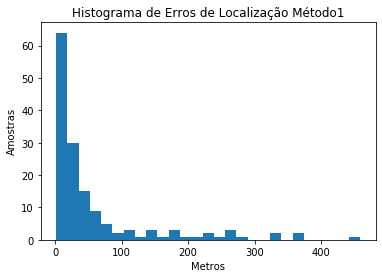

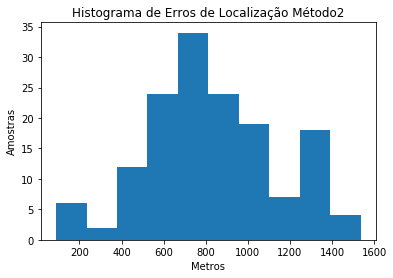

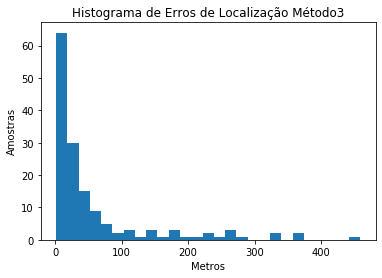

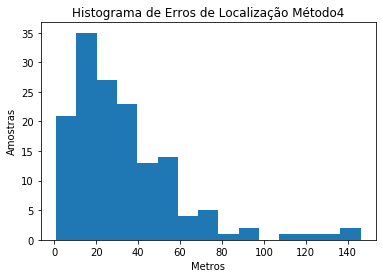

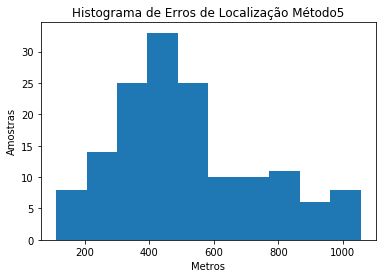

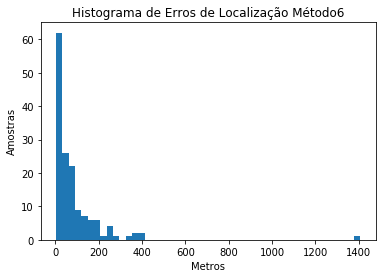

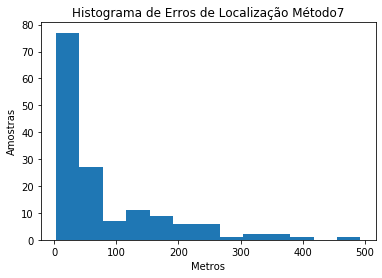

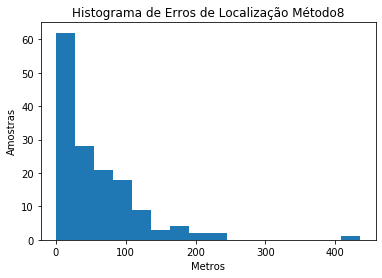

In [4]:
for i in METHODS:
    errorLocation = pd.read_csv(ERROS_CSV_FILE)
    plt.title("Histograma de Erros de Localização Método" + str(i))
    histogram_example = plt.hist(errorLocation[str(i)], bins='auto')
    plt.xlabel('Metros')
    plt.ylabel('Amostras')
    plt.show()

# 3. Boxplot dos erros (em metros)

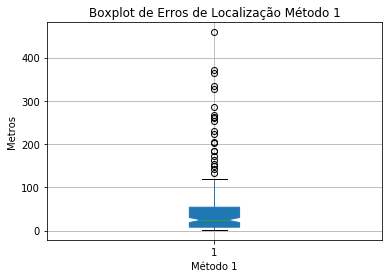

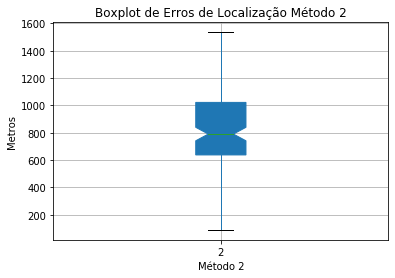

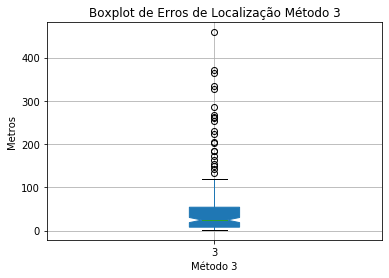

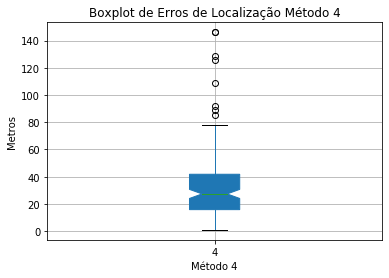

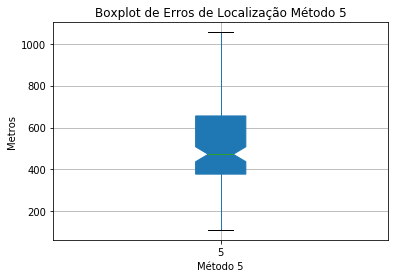

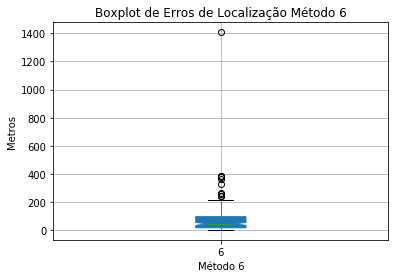

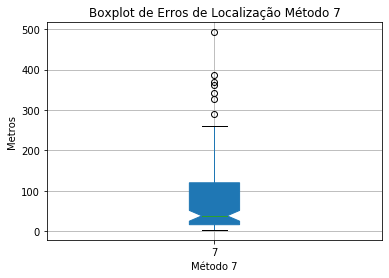

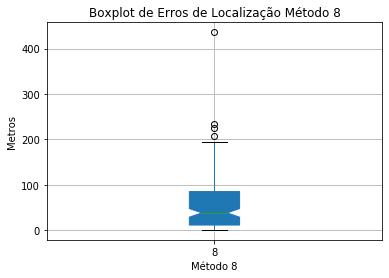

In [5]:
for i in METHODS:
    boxplotErrorLocationM1 = errorLocation.boxplot(column=[str(i)], notch = True, patch_artist = True)
    plt.title("Boxplot de Erros de Localização Método "+ str(i))
    plt.xlabel('Método '+ str(i))
    plt.ylabel('Metros')
    plt.show()

# 4. Mapa de comparação - posições preditas vs. posições reais

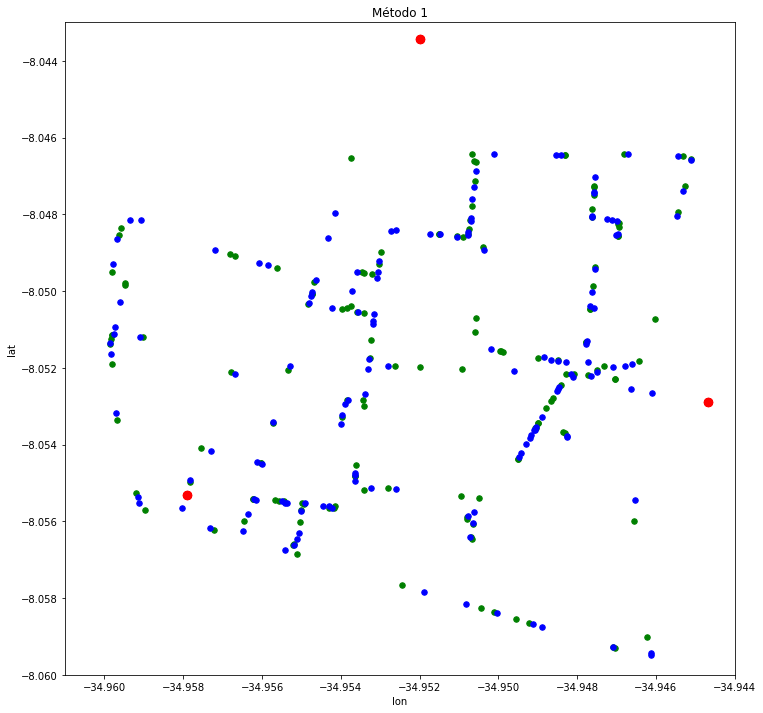

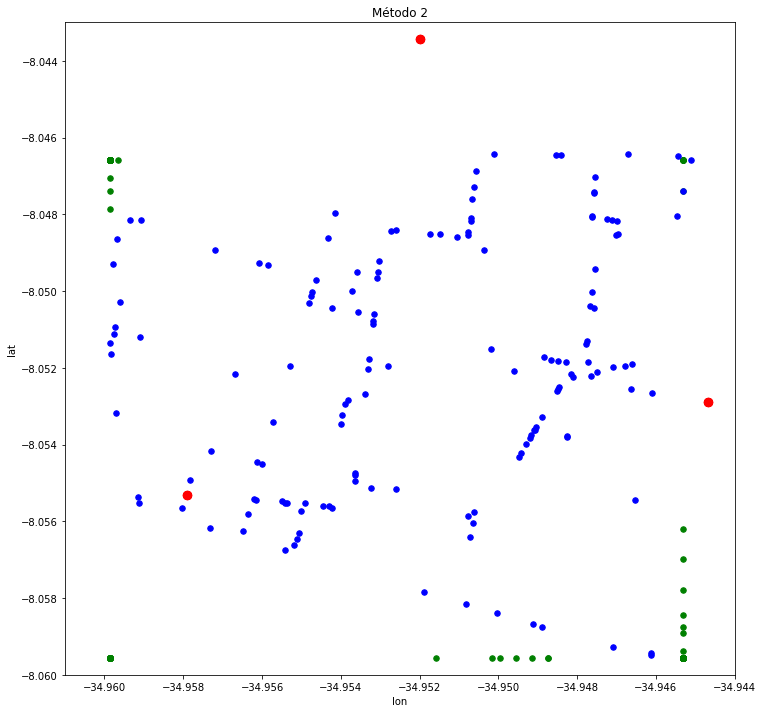

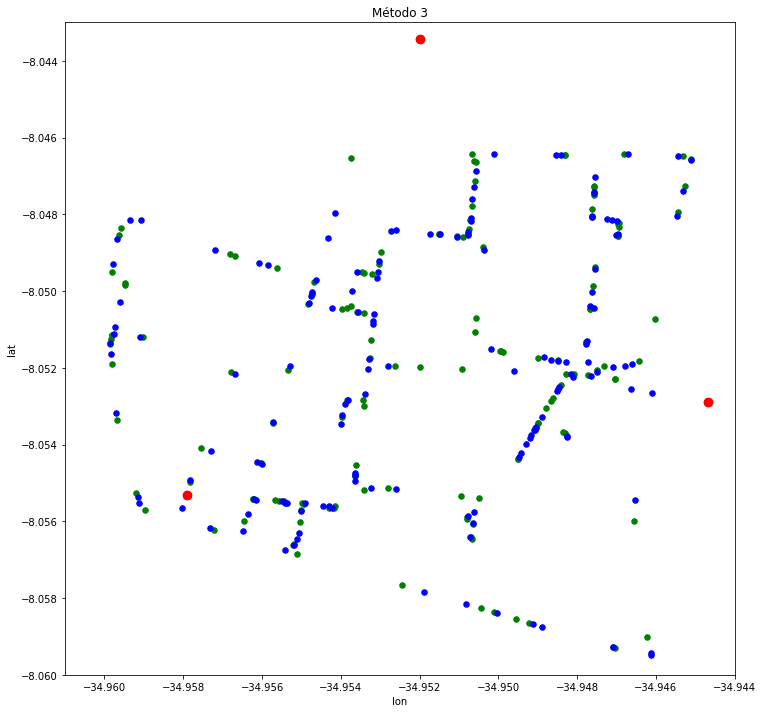

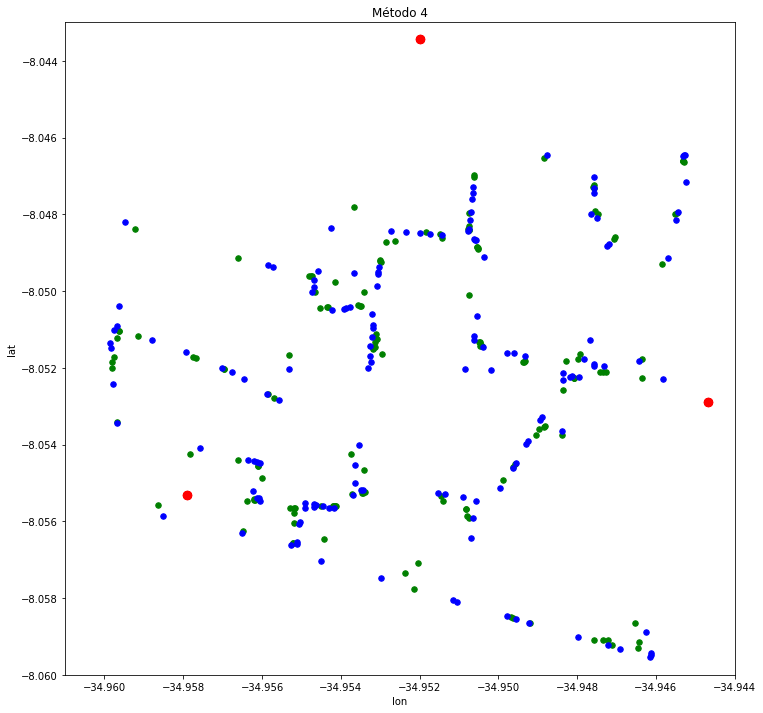

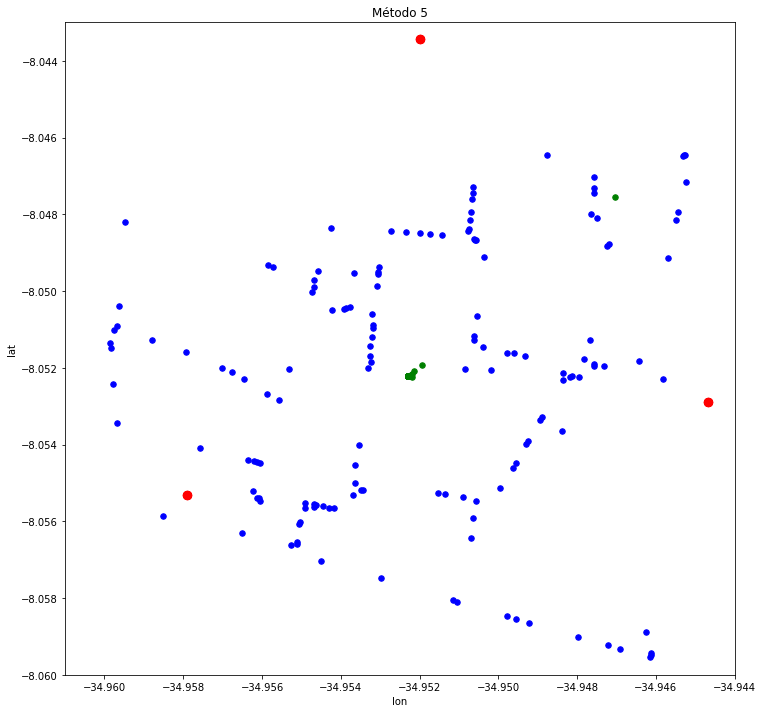

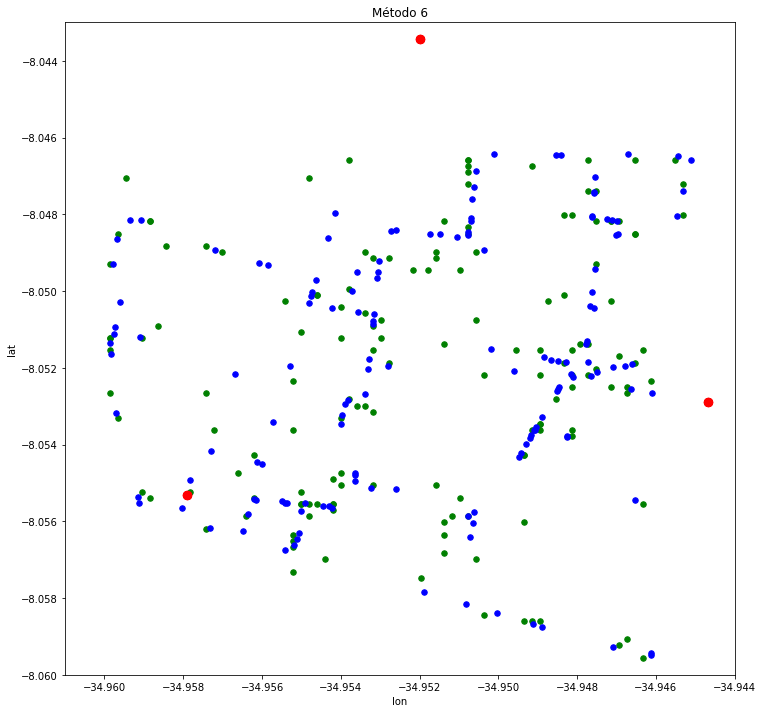

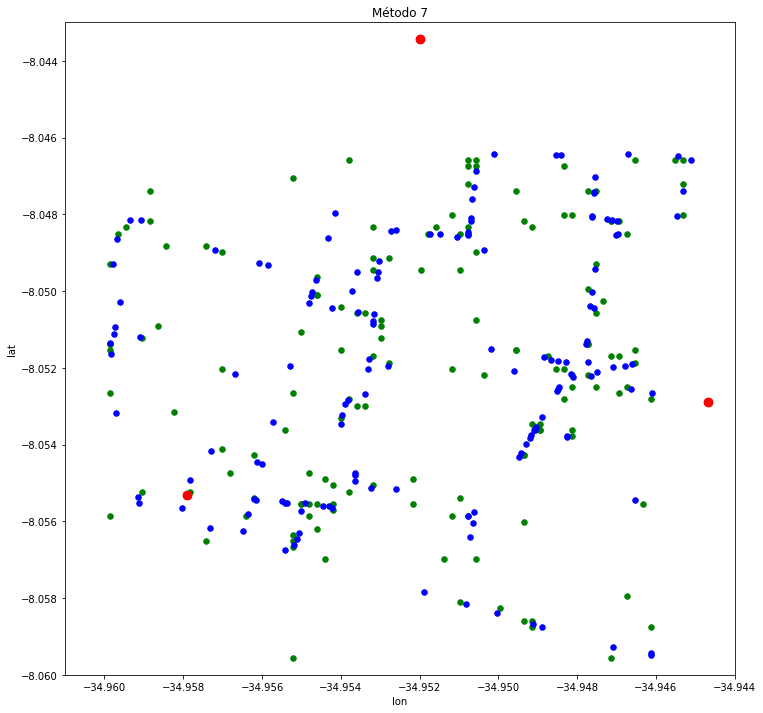

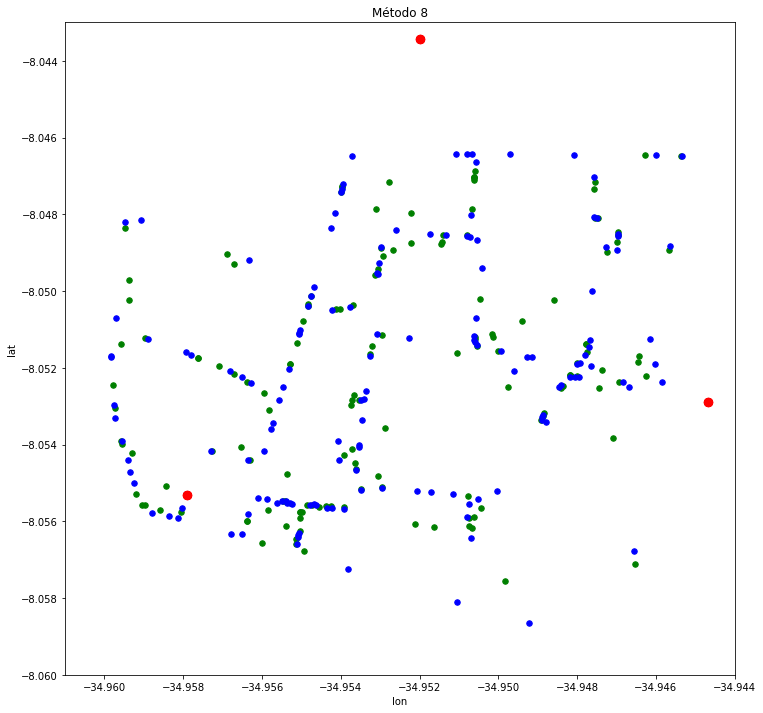

In [6]:
for i in METHODS:
    dbTeorico = pd.read_csv('result/Resultados_Equipe4_Metodo_'+ str(i) +'.csv')
    testMap = merge_on_pontoId(dbTeorico, db)
    cols = ['pontoId','rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3', 'delay_1','delay_2','delay_3']
    testMap = testMap.drop(cols, axis=1)
    fig, ax = plt.subplots()
    ax.scatter(testMap['lon_pred'], testMap['lat_pred'], s = 30, color = 'green', alpha = '1')
    ax.scatter(testMap['lon'], testMap['lat'], s = 30, color = 'blue', alpha = 1)
    ax.scatter(erbs['lon'], erbs['lat'], s = 70, color = 'red', alpha = 1)
    ax.set(xlabel = 'lon', ylabel = 'lat')
    plt.axis([-34.961,-34.944,-8.060,-8.043])
    plt.gcf().set_size_inches((12,12))
    plt.title('Método ' + str(i))
    plt.show()

# 5. Erros de localização médio, mínimo, máximo e desvio padrão

In [7]:
def calculate_errors(df_real, df_predict):
    """
    Retorna uma lista contendo os erros em metros de todos os pontos no real e na predição
    """
    df_merged = merge_on_pontoId(df_predict, df_real)
    errors = []
    
    for idx, point in df_merged.iterrows():
        distance = GeoUtils.distanceInKm(point.lat, point.lon, point.lat_pred, point.lon_pred)
        errors.append(round(distance * 1000, 2))
        
    return errors

def calculate_theorical_errors():
    df_real = pd.read_csv("./database/LocTreino_Equipe_4.csv")
    dict_errors = {}
    
    for file, method in zip(FILES,METHODS):
        df_predict = pd.read_csv(file)
        dict_errors[method] = calculate_errors(df_real, df_predict)
    
    return pd.DataFrame(dict_errors)

In [8]:
# Gera o dataframe contendo os erros
errors_df = calculate_theorical_errors()
round(errors_df.describe(), 2)

,1,2,3,4,5,6,7,8
count,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00
mean,58.26,837.39,58.26,33.49,516.46,83.44,78.64,56.27
std,86.41,308.27,86.41,26.82,224.06,136.66,93.03,60.41
min,1.56,89.41,1.56,0.89,111.43,3.08,3.08,0.37
25%,7.88,638.14,7.88,15.79,377.63,18.19,16.02,11.11
50%,24.38,790.89,24.38,27.34,472.44,45.86,38.03,37.94
75%,54.05,1022.47,54.05,41.78,655.31,97.15,119.81,84.88
max,458.76,1535.82,458.76,146.11,1054.71,1407.65,492.58,436.01


In [9]:
errors_df.to_csv(ERROS_CSV_FILE, index=False)